# Imports and functions

In [9]:
import segmentation_models_pytorch as smp
import os
import cv2
import random
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import csv
import copy

In [10]:
def list_files(path, ext=None):
    result = []
    for name in os.listdir(path):
        full_path = os.path.join(path, name)
        if ext is not None:
            if not full_path.endswith(ext):
                continue
        result.append(full_path)
    return result

# Model initialization

### You may need to make some fixes to segmentation_models_pytorch to properly load weights to CPU device

In [11]:
CUDA = "cuda:0"
CPU = "cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

NET = smp.create_model(
    "Linknet", encoder_name='mobileone_s2',
    in_channels=3, classes=1
)

BEST_PATH = 'mobileone_best.pth.24.pth'
NET.to(device)
NET.load_state_dict(torch.load(BEST_PATH, map_location=device))
NET.eval()

def reparameterize_model(model: torch.nn.Module) -> torch.nn.Module:
    """Return a model where a multi-branched structure
        used in training is re-parameterized into a single branch
        for inference.

    :param model: MobileOne model in train mode.
    :return: MobileOne model in inference mode.
    """
    # Avoid editing original graph
    model = copy.deepcopy(model)
    for module in model.modules():
        if hasattr(module, "reparameterize"):
            module.reparameterize()
    return model

NET.encoder = reparameterize_model(NET.encoder)
print('Done!')

Done!


In [12]:
path_list = list_files('landuse_czech_5120_z16')
print(len(path_list))

3838


# Uncertainty mining

### Mine

In [13]:
results = []
random.shuffle(path_list)
for image_path in tqdm(path_list):
    image = cv2.imread(image_path)

    image_t = torch.unsqueeze(torch.from_numpy(image), dim=0).permute(0, 3, 1, 2) / 255
    
    pred = NET(image_t).sigmoid()
    pred = torch.squeeze(pred)
    ones = torch.ones_like(pred)
    uncertainty = ones - torch.abs((pred - (ones*0.5)) *2)

    pred = pred.detach().cpu().numpy()
    uncertainty = uncertainty.detach().cpu().numpy()
    item = {'path': image_path,
            'uncertainty':np.sum(uncertainty)}
    
    results.append(item)
    fields = [i for i in results[0].keys()]
    with open('stats_o3.csv', 'w', newline='') as f: 
        writer = csv.DictWriter(f, fieldnames = fields)
        writer.writeheader() 
        writer.writerows(results)

100%|███████████████████████████████████████| 3838/3838 [22:00<00:00,  2.91it/s]


### Show results

uncertainty 2595.761


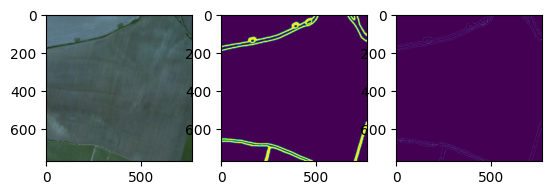

uncertainty 9564.176


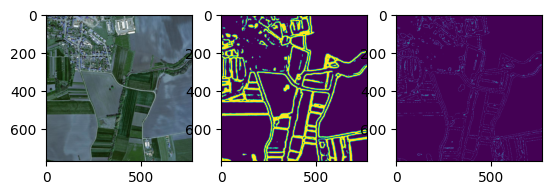

uncertainty 9558.5205


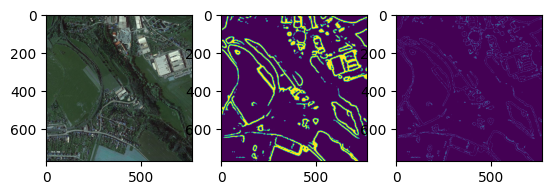

uncertainty 9550.65


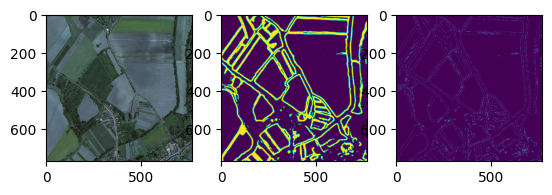

uncertainty 9548.076


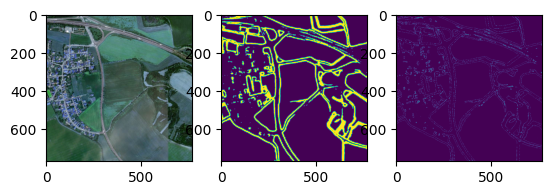

In [16]:
results = sorted(results, key=lambda x: x['uncertainty'])
for j in range(5):
    i = results[-j]
    print('uncertainty', i['uncertainty'])
    image_path = i['path']
    image = cv2.imread(image_path)

    image_t = torch.unsqueeze(torch.from_numpy(image), dim=0).permute(0, 3, 1, 2) / 255
    pred = torch.squeeze(NET(image_t).sigmoid())
    ones = torch.ones_like(pred)
    uncertainty = ones - torch.abs((pred - (ones*0.5)) *2)

    pred = pred.detach().cpu().numpy()
    uncertainty = uncertainty.detach().cpu().numpy()
    item = {'path': image_path,
            'uncertainty':np.sum(uncertainty)}

    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(image.astype(np.uint8))
    axarr[1].imshow(pred)
    axarr[2].imshow(uncertainty)
    plt.show()

### Move to separate folder

In [12]:
import shutil

for j in range(256):
    i = results[-j]
    image_path = i['path']
    shutil.move(image_path, 'u256')

# Inference

### OneDNN optimization

In [17]:
torch.jit.enable_onednn_fusion(True)
sample_input = [torch.rand(1, 3, 768, 768)]
NET.training = False
NET = torch.jit.trace(NET, sample_input)
NET = torch.jit.freeze(NET)
torch.jit.save(NET, 'scriptmodule.pt')

/home/userlp/my/segment-anything/sa_venv/lib/python3.10/site-packages/segmentation_models_pytorch/base/model.py:16: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if h % output_stride != 0 or w % output_stride != 0:


### Show final results

  0%|                                                     | 0/5 [00:00<?, ?it/s]

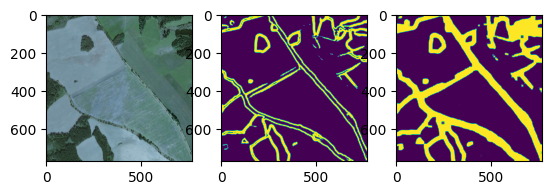

 20%|█████████                                    | 1/5 [00:00<00:02,  1.54it/s]

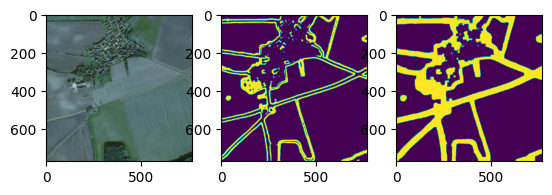

 40%|██████████████████                           | 2/5 [00:01<00:02,  1.48it/s]

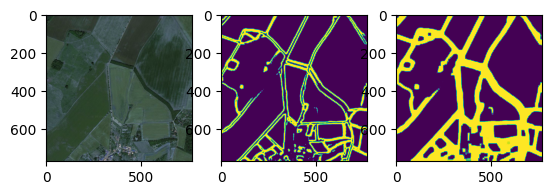

 60%|███████████████████████████                  | 3/5 [00:01<00:01,  1.58it/s]

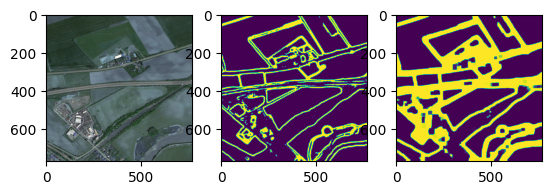

 80%|████████████████████████████████████         | 4/5 [00:02<00:00,  1.65it/s]

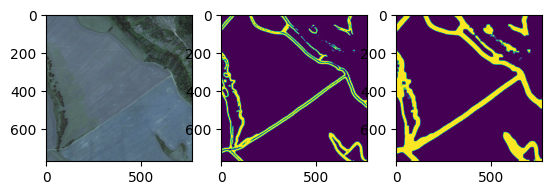

100%|█████████████████████████████████████████████| 5/5 [00:03<00:00,  1.64it/s]


In [20]:
results = []
random.shuffle(path_list)
for image_path in tqdm(path_list[:5]):
    image = cv2.imread(image_path)

    image_t = torch.unsqueeze(torch.from_numpy(image), dim=0).permute(0, 3, 1, 2) / 255
    
    # Run inference
    pred = NET(image_t).sigmoid()
    
    # Add some postprocessing to remove holes and small objects
    pred_pp = torch.nn.functional.max_pool2d(pred, kernel_size=19, stride=1, padding=19 // 2)
    pred_pp = -torch.nn.functional.max_pool2d(-pred_pp, kernel_size=19, stride=1, padding=19 // 2)
    
    pred_pp = torch.nn.functional.max_pool2d(pred_pp, kernel_size=11, stride=1, padding=11 // 2)
    pred_pp = -torch.nn.functional.max_pool2d(-pred_pp, kernel_size=5, stride=1, padding=5 // 2)
    
    pred = torch.squeeze(pred).detach().cpu().numpy()
    pred_pp = torch.squeeze(pred_pp).detach().cpu().numpy()
    
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(image.astype(np.uint8))
    axarr[1].imshow(pred)
    axarr[2].imshow(pred_pp)
    plt.show()